# Imports

In [36]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import trange

# Matrix Generators


Let's build different topology of network. 

For the sake of benchmarking, it is interesting to have control on the number of node and the average number of edges per node. That's why some function were re-implmented.

But first, here is a function that gives some informations about the network that will be built.

Note : All network are represnted throught their incidence matrix.

In [37]:
def info_graph(A) :
  G = nx.from_numpy_array(A)
  print("Average number of edges : ",sum(sum(A))/len(A))
  #print("Sigma Coefficient (sw if >1) : ", nx.sigma(G))
  #print("Omega Coefficient (sw if 0) : ", nx.omega(G))
  plt.figure()
  plt.imshow(A)
  plt.figure()
  plt.plot(nx.degree_histogram(nx.from_numpy_array(A)))
  plt.xlabel("Degree")
  plt.ylabel("Frequency")

Average number of edges :  63.53515625


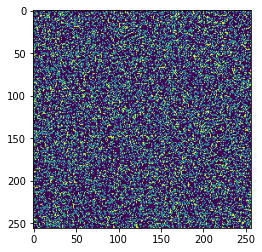

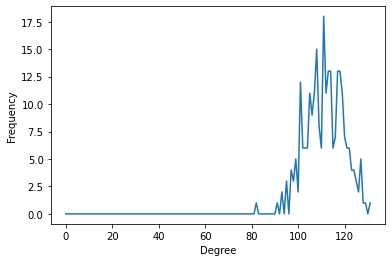

In [38]:
# Function that create a random graph
def create_random(N,  k_avg):
  ret = np.zeros((N, N))
  A = np.random.uniform(size=(N,N))
  ret[:N,:N] = np.array(1*(A<(k_avg/N)))
  return ret

info_graph(create_random(256, 64))

Average number of edges :  64.0


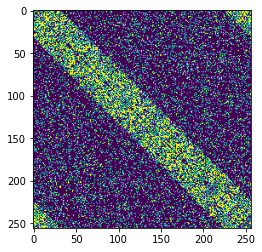

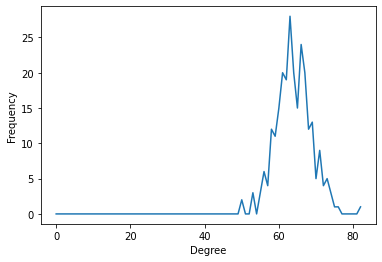

In [39]:
# Function that create a Small wolrd Watts Stoggart network.
def create_WS(N, k_avg, p_drop = 0.5):
  A = np.zeros((N, N))
  G = nx.connected_watts_strogatz_graph(N, k_avg, p_drop)
  A[:N, :N] = nx.to_numpy_array(G)#[K:,K:]
  return A

info_graph(create_WS(256, 64))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Average number of edges :  11.796875


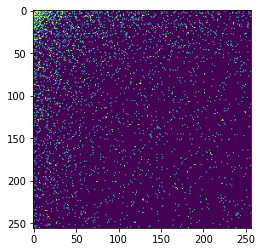

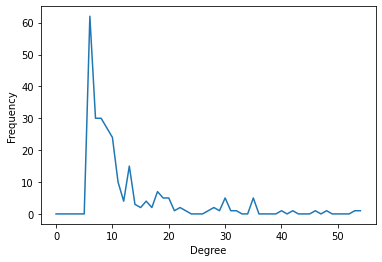

In [40]:

# Create a Barabasi-Albert network
def BA(N, M0, m) :
    """
        N, number of nodes in the final network.
        M0, initial connected network of M0 nodes.
        m, Each new node is connected to m existing nodes.
    """
    assert( M0 < N )
    assert( m <= M0 )
    
    #adjacency matrix
    AM = np.zeros((N,N))
    
    for i in range(0, M0):
        for j in range(i+1,M0):
            AM[i,j] = 1
            AM[j,i] = 1
    
    # add 'c' node
    for c in range(M0,N):
        Allk = np.sum(AM)  # all  degree    Eki
        ki = np.sum(AM , axis = 1)   # ki each degree for node i
        
        pi = np.zeros(c,dtype=np.float) # probability
        for i in range(0,c):
            pi[i] = ki[i]/(Allk*1.0)
        # print pi
    
        # connect m edges.
        for d in range(0,m):
            rand01 = np.random.random()  #[0,1.0)
            
            sumpi = 0.0
            for g in range(0,c):
                sumpi += pi[g]
                if sumpi>rand01 :  # connect 'c' node with 'g' node.
                    if AM[c,g]==0 and AM[g,c]==0 :
                        AM[c,g] += 1
                        AM[g,c] += 1                    
                        break
    
    return AM    

# Build a Barabasi-Albert Network with same M0 = m and with the right average number of edges per node.
def create_BA(N, k_avg):
  M = int((-1+2*N-((1-2*N)**2-4*N*k_avg)**(1/2))//2)+1
  return BA(N,M,M)

A = create_BA(256,10)
info_graph(A)



Average number of edges :  127.9921875


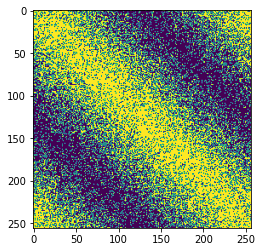

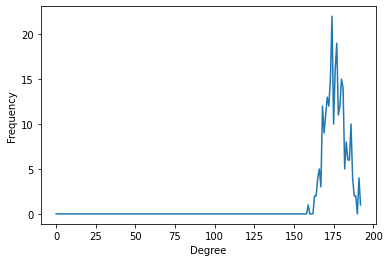

In [41]:
def gaussian_connect(N, sigma, mu, tol=1e-6, quantile_max=30):
    alpha = 3 / quantile_max ** 2 - norm.cdf(-quantile_max) / norm.pdf(-quantile_max) * 3 / quantile_max
    assert mu ** 2 / 12 * (1 + alpha) < sigma ** 2, "Error: mu ** 2 / 12 > sigma ** 2"
    assert sigma ** 2 < N ** 2 / 12, "Error: sigma ** 2 > N ** 2 / 12"
    mu_target = mu
    sigma_target = sigma
    margin = sigma * np.sqrt(np.maximum(np.log(mu ** 2 / 2 / np.pi / sigma ** 2), 0))
    while True:        
        cdf_diff = norm.cdf(- margin / sigma) - norm.cdf(- N / 2 / sigma)
        if margin:
            mu = np.sqrt(2 * np.pi) * sigma * np.exp(margin ** 2 / 2 / sigma ** 2)
        else:
            mu = mu_target / 2 / cdf_diff
        b = - mu * np.sqrt(2 / np.pi) * N / 2 * np.exp(- (N / 2) ** 2 / 2 / sigma ** 2) / mu_target
        c = 2 / 3 * margin ** 3 / mu_target - sigma_target ** 2
        if np.abs(2 * mu * cdf_diff + 2 * margin - mu_target) < tol and \
            np.abs(sigma ** 2 + b * sigma + c) < tol:
            break
        sigma = np.sqrt(- (c + b * sigma))
        if margin:
            margin = np.maximum(mu_target / 2 - mu * cdf_diff, 0)
        else:
            margin = sigma * np.sqrt(np.maximum(np.log(mu ** 2 / 2 / np.pi / sigma ** 2), 0))
    x, y = np.meshgrid(range(N), range(N))
    d = np.minimum(np.mod(x - y, N), np.mod(y - x, N))
    return np.random.rand(N, N) <= mu / np.sqrt(2 * np.pi) / sigma * np.exp(- d ** 2 / 2 / sigma ** 2)


# Create a network with a connectivity such that the probability of two nodes to be connected
# follow a normal distribution along the distance of these two nodes
def create_diago_chenxi(N, k_avg) :
  A = np.zeros((N, N))
  quantile_max = 30
  alpha = 3 / quantile_max ** 2 - norm.cdf(-quantile_max) / norm.pdf(-quantile_max) * 3 / quantile_max
  min_sigma = (k_avg ** 2 / 12 * (1 + alpha))**(1/2) 
  max_sigma = (N ** 2 / 12)**(1/2)
  g = gaussian_connect(N, (min_sigma+max_sigma)*(1/2), k_avg)
  A[:N, :N] = g
  return A


A = create_diago_chenxi(256, 128)
info_graph(A)

# Implemeting the mapping algorithm

Here is the algorithm. 
It consists in switching the label of nodes. The underlying network remains the same, but not its incidency matrix. It is a greedy algorithm that search the best representation of the network. It maximizes a cost function that reperesnt the similarity with the Mask.


For example, if one wants to build four communities. It means that, those four communities should have as much intra-communities connection and as less as possible inter-commmunities connection. Then the cost function should penalizes the inter-communities connections and reward the intra-communities connections.

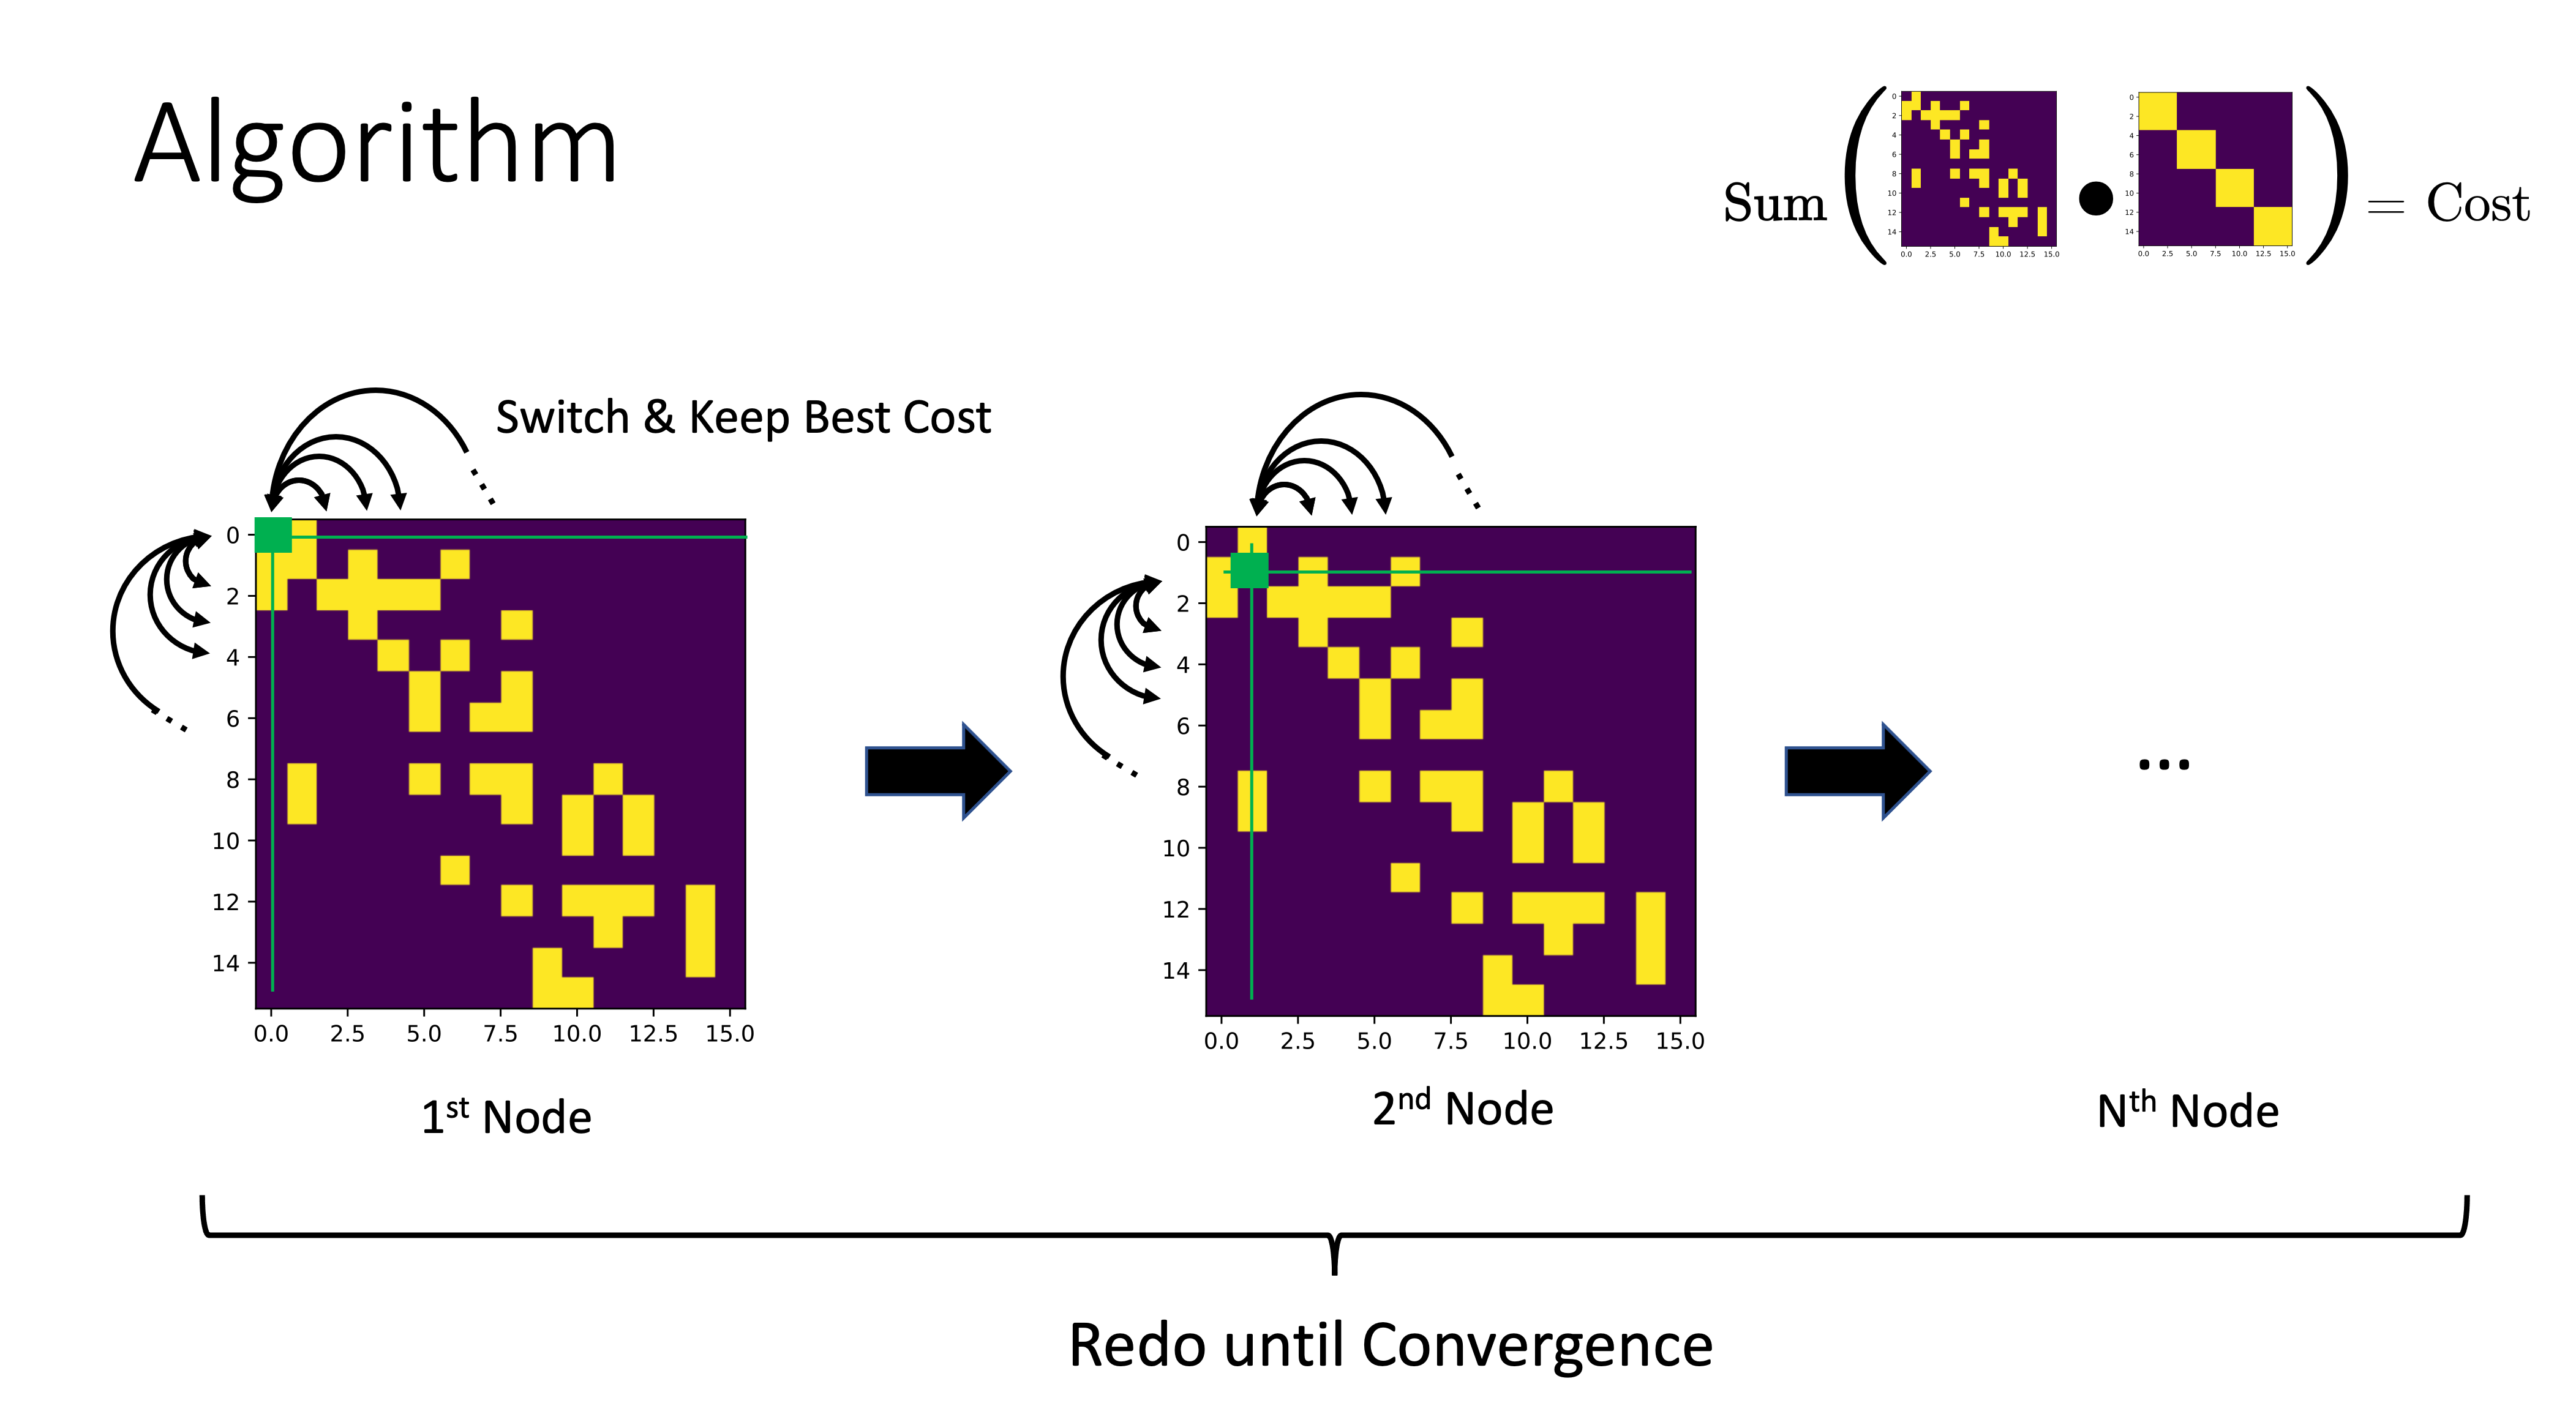

To speed up the execution of the algorithme, let's use numba that allows Just In Time compilation.

In [42]:
from numba import jit

In [43]:
# Implementation of copying an array to use numba
@jit
def copyto_numba(a, b):
    N = len(a)
    for i in range(N):
        b[i] = a[i]

# Swap two node's label in a network. It does not change the network but it's matrix representation
@jit
def swap(A_new, buf, i, j):
  copyto_numba(A_new[i,:], buf)
  #np.copyto(buf, A_new[i,:])
  A_new[i,:] = A_new[j,:]
  A_new[j,:] = buf

  copyto_numba(A_new[:,i],buf)
  #np.copyto(buf, A_new[:,i])
  A_new[:,i] = A_new[:,j]
  A_new[:,j] = buf
  return A_new

# Swap two elements in a list
@jit
def swap_order(order, i, j):
  x = order[i]
  order[i] = order[j]
  order[j] = x 


# Reorder a matrix along new labels
def reorder(partitions, A):
  order_ = np.ndarray.flatten(partitions)
  A_ord_line = np.zeros_like(A)
  for i in range(len(order_)):
    A_ord_line[i] = A[order_[i]]
  A_ord_col = np.zeros_like(A)
  for i in range(len(order_)):
    A_ord_col[:,i] = A_ord_line[:,order_[i]]
  return A_ord_col

# Reorder a list of matrix along a list of labels
def reorder_list(order, l):
  return np.array([l[i] for i in order])

# Shuffle the label of a network. The etwork remains the same but not its incidency matrix.
def shuffle(A):
  A_new = np.copy(A)
  arr = np.arange(len(A_new))
  np.random.shuffle(arr)
  A_new = reorder(arr, A_new)
  return A_new

In [44]:
# Returns the number of common elements between a matrix and a mask.
def cost(A, Mask):
    return (A*Mask).sum()

# Compute the difference of cost function between a matrix A and the same matrix A but with the label i and j switched
@jit
def swap_cost(A, Mask, i, j):
  cost =   (  (A[i,:]*Mask[i,:]).sum()
            + (A[j,:]*Mask[j,:]).sum()
            + (A[:,i]*Mask[:,i]).sum() 
            + (A[:,j]*Mask[:,j]).sum()
            - (A[i,i]*Mask[i,i])
            - (A[j,j]*Mask[j,j])
            - (A[i,j]*Mask[i,j])
            - (A[j,i]*Mask[j,i])  )
    
  return cost

In [45]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

In [46]:
# This function reorder a matrix such that it minimizes a cost computed with the mask.
# The results could vary for the same matrix depending on the shuffling of its incidency matrix.
# In order to have the same results for two different shuffling, one could pre-order it with a reverse-cuthill-mckee order.

# Returns a new reordered matrix and the order applied on the initial matrix.

def mapping(A, Mask, reordering=True, maxIter = 10):

  print("INITIAL COST = ", cost(A, Mask))

  lenght = len(A)
  buf = np.arange(lenght)
  order = np.arange(lenght)

  A_new = A.copy()


  if reordering : 
    graph = csr_matrix(A_new)
    rcm = reverse_cuthill_mckee(graph)
    order = reorder_list(rcm, order)
    A_new = reorder(order, A_new)

  improvement = True
  iter = 0
  while improvement and iter<=maxIter:
    improvement = False
    iter += 1

    for i in trange(lenght, desc = "Iteration number: "+str(iter), leave= True):
      for j in range(lenght):
        cost_old = swap_cost(A_new, Mask, i, j)
        swap(A_new, buf, i, j)
        cost_new = swap_cost(A_new, Mask, i, j)
        if (cost_new > cost_old) : 
          improvement = True
          swap_order(order, i, j)
        else : # if no improvement, unswap
          swap(A_new, buf, i, j)

  print("\nFINAL COST = ", cost(A_new, Mask))
  return A_new  #, order

# Testing the function

Let's first build a Mask. Here it is an example of four communities.

In [47]:
N = 256

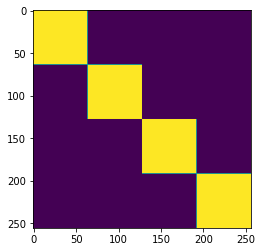

In [48]:
# Create a Mask representing a network of N nodes with C communities
def create_communities(N, C):
  A = np.zeros((N,N))
  for i in range(C):
    A[(N//C)*i:(N//C)*(i+1),(N//C)*i:(N//C)*(i+1)] = 1
  return A.astype(np.int64)

Mask = create_communities(N,4)
plt.imshow(Mask)

Then we need a matrix to be treated. Let's say that matrix observed has a Watt's Stogart topology.

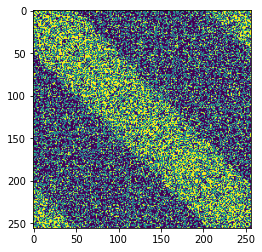

In [51]:
A = create_WS(256,100)
#A = create_diago_chenxi(256,50)
#A = create_random(256,64)
plt.imshow(A)

Let's shuffle the incidency matrix. Remember, the network remains the same.

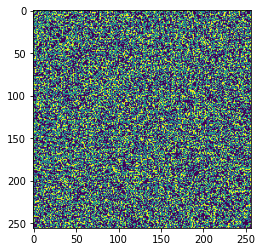

In [52]:
A_shuffled = shuffle(A)
plt.imshow(A_shuffled)

Now let's apply the algorithm !

INITIAL COST =  6448.0


Iteration number: 4: 100%|██████████| 256/256 [00:01<00:00, 205.49it/s]


FINAL COST =  9418.0


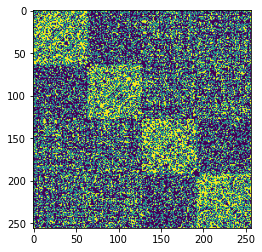

In [59]:
#print("Cost on non-shuffled matrix = ", cost(A, Mask))
Result = mapping(A_shuffled, Mask)
plt.imshow(Result)